# Capstone Project – Image Colorization
## Maxime GENDRE - Udacity - Machine Learning Engineer Nanodegree 

Capstone PDF : https://github.com/MaxGdr/Capstone-Project-Machine-Learning-Engineer-Nanodegree/blob/main/Capstone%20Project%20-%20Image%20Colorization.pdf

### If you don't want to train and just do some predicts, you can get the weights directly :

Best Model Weights : https://drive.google.com/uc?id=1FWGVilTO8DOWC9yDPQYeNx5rnaXG_Iw-&export=download

Exp 01 Weights : https://drive.google.com/uc?export=download&confirm=CDIp&id=1uexevb6_9VgZcO7hrPJMfjCEWxu-mo06

### The purpose of this capstone project is to train a Generative Adversarial Network to colorize grayscale images. You can find below an example of the prediction done by the model trained.
First row is input, Second row is Fake image (Predict) and Third row is the Real Image (Target)

### Result Metric used : Structural Similarity Index (SSIM)
## Mean score on 3K validation samples : 0.87 (1 means perfect similarity)

<img src="./last_train/colorization_1613765691.7192485.png">

You can find in the project folder : 
- exp01 (First train)
- last_train (Last train with logs and pickle of dict with Loss / SSIM per epoch)
- predict_results_sample (Example of predict results on Validation Dataset) 
    - See at the bottom of the notebook to get SSIM with each predict (better)
- requirements.txt (Dependencies to execute this notebook)

Uncomment the cell below to install dependencies

In [ ]:
#!pip install -r requirements.txt

## Imports

In [169]:
import pickle
import os
import time
from glob import glob
from statistics import mean

from tqdm import tqdm
import numpy as np
import PIL

import matplotlib
import matplotlib.pyplot as plt

from PIL import Image

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import torchvision.models
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.models.resnet import model_urls
from torchvision.models.resnet import resnet18

from skimage import img_as_float
from skimage import exposure
from skimage.color import rgb2lab
from skimage.color import lab2rgb
from skimage.io import imread
from skimage.io import imshow
from skimage.metrics import structural_similarity as ssim

import fastai
from fastai.vision.learner import create_body
from fastai.vision.models.unet import DynamicUnet
from fastai.data.external import untar_data
from fastai.data.external import URLs

## Download Coco Dataset

In [4]:
coco_path = untar_data(URLs.COCO_SAMPLE)
coco_path = str(coco_path) + "/train_sample"

## Utils Functions

In [168]:
def plot_img_and_hist(img, axes, bins=256):
    """Plot an image along with its histogram and cumulative histogram.

    """
    img = img_as_float(img)
    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()

    # Display image
    ax_img.imshow(img, cmap=plt.cm.gray)
    ax_img.set_axis_off()
    #ax_img.set_adjustable('box-forced')

    # Display histogram
    ax_hist.hist(img.ravel(), bins=bins, histtype='step', color='black')
    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax_hist.set_xlabel('Pixel intensity')
    ax_hist.set_xlim(0, 1)
    ax_hist.set_yticks([])

    # Display cumulative distribution
    img_cdf, bins = exposure.cumulative_distribution(img, bins)
    ax_cdf.plot(bins, img_cdf, 'r')
    ax_cdf.set_yticks([])

    return ax_img, ax_hist, ax_cdf

def print_image_summary(image, labels):
    print(f'Image dimensions: {image.shape}')
    print('Channels:')
    if len(labels) == 1:
        image = image[..., np.newaxis]
    for i, lab in enumerate(labels):
        min_val = np.min(image[:,:,i])
        max_val = np.max(image[:,:,i])
        print(f'{lab} : min={min_val:.4f}, max={max_val:.4f}')

                
def log_results(loss_meter_dict):
    for loss_name, loss_meter in loss_meter_dict.items():
        print(f"{loss_name}: {loss_meter.avg:.5f}")
        
def visualize(model, data, tracer=None, loss_meter_dict=None, save=True):
    """
    Predict with Generator to generate a Fake images for a batch (data) from data loader.
    Create a dict "tracer" to store metrics
    Plot Grayscale / Fake / Real Images to compare.
    """
    model.net_G.eval()
    with torch.no_grad():
        model.setup_input(data)
        model.forward()
    model.net_G.train()
    fake_color = model.fake_color.detach()
    real_color = model.ab
    l = model.l
    fake_imgs = lab_to_rgb(l, fake_color)
    real_imgs = lab_to_rgb(l, real_color)
    fig = plt.figure(figsize=(15, 8))
    if tracer is not None and loss_meter_dict is not None and len(fake_imgs) == len(real_imgs):
        tracer['data'] = {
                "loss_meter_dict": loss_meter_dict,
                
            }
    ssim_list = []
    for i in range(5):
        l_img = l[i][0].cpu()
        fake_img = fake_imgs[i]
        real_img = real_imgs[i]
        ssim_metric = ssim(fake_img, real_img, data_range=real_img.max() - real_img.min(), multichannel=True)
        ssim_list.append(ssim_metric)
        label = 'FAKE vs REAL SSIM: {:.2f}'
        ax = plt.subplot(3, 5, i + 1)
        ax.imshow(l_img, cmap='gray')
        ax.set_title('GRAY')
        ax = plt.subplot(3, 5, i + 1 + 5)
        ax.imshow(fake_img)
        ax.set_title('FAKE')
        ax.set_xlabel(label.format(ssim_metric))
        ax = plt.subplot(3, 5, i + 1 + 10)
        ax.imshow(real_img)
        ax.set_title('REAL')
    if tracer is not None and loss_meter_dict is not None and len(fake_imgs) == len(real_imgs):
        tracer['data']['ssim_mean'] = mean(ssim_list)
    plt.tight_layout()
    plt.show()
    if save:
        fig.savefig(f"colorization_{time.time()}.png")
    return tracer

def get_perf_on_val(model, dataloader):
    """
        Get SSIM Mean from a given model and dataloader (Generator and Validation Dataloader)
    """
    model.net_G.eval()
    ssim_list = []
    for data in dataloader:
        with torch.no_grad():
            model.setup_input(data)
            model.forward()
        model.net_G.train()
        fake_color = model.fake_color.detach()
        real_color = model.ab
        l = model.l
        fake_imgs = lab_to_rgb(l, fake_color)
        real_imgs = lab_to_rgb(l, real_color)
        for fake_img, real_img in zip(fake_imgs, real_imgs):
            ssim_metric = ssim(fake_img, real_img, data_range=fake_img.max() - fake_img.min(), multichannel=True)
            ssim_list.append(ssim_metric)
    return mean(ssim_list)
        
def init_weights(net, init='norm', gain=0.02):
    """
        Init weights
    """
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and 'Conv' in classname:
            if init == 'norm':
                nn.init.normal_(m.weight.data, mean=0.0, std=gain)
            elif init == 'xavier':
                nn.init.xavier_normal_(m.weight.data, gain=gain)
            elif init == 'kaiming':
                nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            
            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias.data, 0.0)
        elif 'BatchNorm2d' in classname:
            nn.init.normal_(m.weight.data, 1., gain)
            nn.init.constant_(m.bias.data, 0.)
            
    net.apply(init_func)
    print(f"model initialized with {init} initialization")
    return net

def init_model(model, device):
    """
        init model to device and call init weights
    """
    model = model.to(device)
    model = init_weights(model)
    return model

def create_loss_meters():
    """
        Use AverageMeter Class and return dict of loss
    """
    loss_D_fake = AverageMeter()
    loss_D_real = AverageMeter()
    loss_D = AverageMeter()
    loss_G_GAN = AverageMeter()
    loss_G_L1 = AverageMeter()
    loss_G = AverageMeter()
    
    return {'loss_D_fake': loss_D_fake,
            'loss_D_real': loss_D_real,
            'loss_D': loss_D,
            'loss_G_GAN': loss_G_GAN,
            'loss_G_L1': loss_G_L1,
            'loss_G': loss_G}

def update_losses(model, loss_meter_dict, count):
    """
        Update a given loss dict
    """
    for loss_name, loss_meter in loss_meter_dict.items():
        loss = getattr(model, loss_name)
        loss_meter.update(loss.item(), count=count)

def lab_to_rgb(l, ab):
    """
    Takes a batch of images, convert each image from lab to rgb & stack it
    """
    
    l = (l + 1.) * 50.
    ab = ab * 110.
    lab = torch.cat([l, ab], dim=1).permute(0, 2, 3, 1).cpu().numpy()
    rgb_imgs = []
    for img in lab:
        img_rgb = lab2rgb(img)
        rgb_imgs.append(img_rgb)
    return np.stack(rgb_imgs, axis=0)
        
def log_results(loss_meter_dict):
    for loss_name, loss_meter in loss_meter_dict.items():
        print(f"{loss_name}: {loss_meter.avg:.5f}")
        
def pretrain_generator(net_G, train_dl, opt, criterion, epochs):
    for e in range(epochs):
        loss_meter = AverageMeter()
        for data in tqdm(train_dl):
            l, ab = data['L'].to(device), data['ab'].to(device)
            preds = net_G(l)
            loss = criterion(preds, ab)
            opt.zero_grad()
            loss.backward()
            opt.step()
            loss_meter.update(loss.item(), l.size(0))
        print(f"Epoch {e + 1}/{epochs}")
        print(f"L1 Loss: {loss_meter.avg:.5f}")

def train_model(model, train_dataloader, validation_dataloader, epochs, display_every=100):
    """
        Train model method.
    """
    tracers = []
    data = next(iter(validation_dataloader)) # getting a batch for visualizing the model output after fixed intervals
    for e in range(epochs):
        tracer = {}
        tracer['epoch'] = e+1
        loss_meter_dict = create_loss_meters() # function returing a dictionary of objects to 
        i = 0                                  # log the losses of the complete network
        for data in tqdm(train_dataloader):
            model.setup_input(data) 
            model.optimize()
            update_losses(model, loss_meter_dict, count=data['L'].size(0)) # function updating the log objects
            i += 1
            if i % display_every == 0:
                
                print(f"\nEpoch {e+1}/{epochs}")
                print(f"Iteration {i}/{len(train_dataloader)}")
                log_results(loss_meter_dict) # function to print out the losses
                tracer = visualize(model, data, tracer, loss_meter_dict, save=True) # function displaying the model's outputs
                tracers.append(tracer)
    with open('train_02.pickle', 'wb') as handle:
        pickle.dump(tracers, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Prepare Train & Validation paths 

In [8]:
paths = glob(coco_path + "/*.jpg")
np.random.seed(98)
paths_data = np.random.choice(paths, 12000, replace=False)
random_indexes = np.random.permutation(12000)
t_i = random_indexes[:9000] 
v_i = random_indexes[9000:]
train_paths = paths_data[t_i]
validation_paths = paths_data[v_i]
print(f"The dataset is composed by {len(train_paths)} images in Train")
print(f"The dataset is composed by {len(validation_paths)} images in Validation")
print(f"The dataset is composed by {len(random_indexes)} images in Total")

The dataset is composed by 9000 images in Train
The dataset is composed by 3000 images in Validation
The dataset is composed by 12000 images in Total


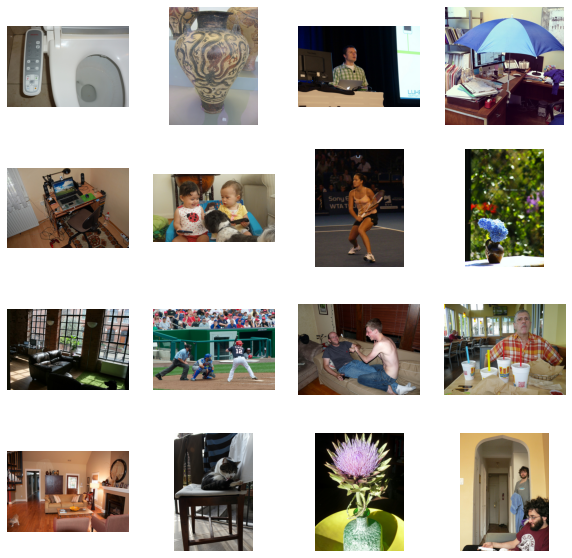

In [9]:
_, axes = plt.subplots(4, 4, figsize=(10, 10))
for ax, img_path in zip(axes.flatten(), train_paths):
    ax.imshow(imread(img_path))
    ax.axis("off")

## Contrast Observation

/home/77788r/.conda/envs/colorization/lib/python3.7/site-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/home/77788r/.conda/envs/colorization/lib/python3.7/site-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/home/77788r/.conda/envs/colorization/lib/python3.7/site-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/home/77788r/.conda/envs/colorization/lib/python3.7/site-packages/skimage/exposure/exposure.py

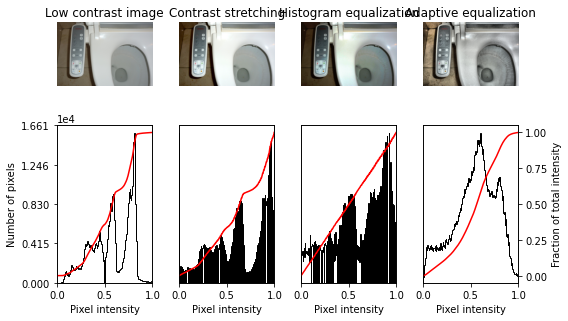

In [10]:
img = imread(train_paths[0])
# Contrast stretching
p2, p98 = np.percentile(img, (2, 98))
img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))

# Equalization
img_eq = exposure.equalize_hist(img)

# Adaptive Equalization
img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)

# Display results
fig = plt.figure(figsize=(8, 5))
axes = np.zeros((2, 4), dtype=np.object)
axes[0, 0] = fig.add_subplot(2, 4, 1)
for i in range(1, 4):
    axes[0, i] = fig.add_subplot(2, 4, 1+i, sharex=axes[0,0], sharey=axes[0,0])
for i in range(0, 4):
    axes[1, i] = fig.add_subplot(2, 4, 5+i)

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img, axes[:, 0])
ax_img.set_title('Low contrast image')

y_min, y_max = ax_hist.get_ylim()
ax_hist.set_ylabel('Number of pixels')
ax_hist.set_yticks(np.linspace(0, y_max, 5))

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_rescale, axes[:, 1])
ax_img.set_title('Contrast stretching')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_eq, axes[:, 2])
ax_img.set_title('Histogram equalization')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_adapteq, axes[:, 3])
ax_img.set_title('Adaptive equalization')

ax_cdf.set_ylabel('Fraction of total intensity')
ax_cdf.set_yticks(np.linspace(0, 1, 5))

# prevent overlap of y-axis labels
fig.tight_layout()
plt.show()

I could use an Histogram Equalization before transform an image to L & ab, but i won't. I prefer to train model on native images, my model will be more generalist in this way

In [129]:
img.shape

(427, 640, 3)

In [130]:
image_lab.shape

(427, 640, 3)

## Observation of different L*a*b* channels

In [11]:
image_lab = rgb2lab(img / 255)
image_lab_scaled = (image_lab + [0, 128, 128]) / [100, 255, 255]

In [12]:
print_image_summary(image_lab, ['L', 'a', 'b'])

Image dimensions: (427, 640, 3)
Channels:
L : min=2.8592, max=100.0000
a : min=-33.8076, max=51.8603
b : min=-33.7266, max=59.2100


In [13]:
print_image_summary(image_lab_scaled, ['L', 'a', 'b'])

Image dimensions: (427, 640, 3)
Channels:
L : min=0.0286, max=1.0000
a : min=0.3694, max=0.7053
b : min=0.3697, max=0.7342


## Plot Channels Lab

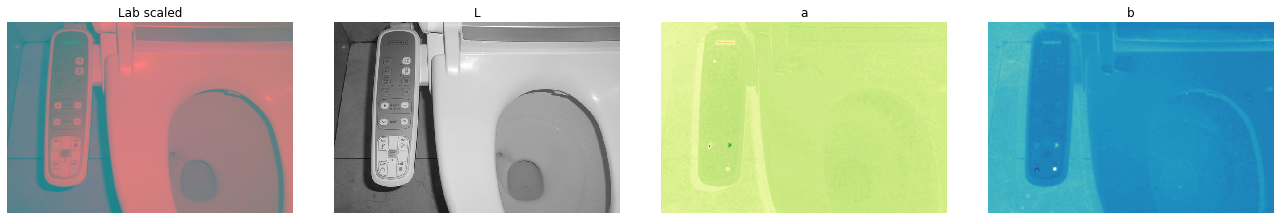

In [14]:
fig, ax = plt.subplots(1, 4, figsize = (18, 30))
ax[0].imshow(image_lab_scaled) # Full channel
ax[0].axis('off')
ax[0].set_title('Lab scaled')
imshow(image_lab_scaled[:,:,0], ax=ax[1]) # L Channel
ax[1].axis('off')
ax[1].set_title('L')
ax[2].imshow(image_lab_scaled[:,:,1], cmap='RdYlGn_r') # a Channel
ax[2].axis('off')
ax[2].set_title('a')
ax[3].imshow(image_lab_scaled[:,:,2], cmap='YlGnBu_r') # b Channel
ax[3].axis('off')
ax[3].set_title('b')
    
plt.show()

## Define Dataset Class 

In [15]:
SIZE = 256
class ColorizationDataset(Dataset):
    def __init__(self, paths, split='train'):
        super(Dataset).__init__()
        if split == 'train':
            # Transform section for "train". 
            # 1. Resize (To 256 in our case)
            # 2. Random horizontal flip to do a little data augmentation
            self.transforms = transforms.Compose([
                transforms.Resize((SIZE, SIZE),  Image.BICUBIC),
                transforms.RandomHorizontalFlip(), 
            ])
        elif split == 'validation':
            self.transforms = transforms.Resize((SIZE, SIZE),  Image.BICUBIC)
        
        self.split = split
        self.size = SIZE
        self.paths = paths
    
    def __getitem__(self, idx):
        """
            Method triggered on get on ColorizationDataset object
        """
        img = Image.open(self.paths[idx]).convert("RGB")
        img = self.transforms(img)
        img = np.array(img) 
        img_lab = rgb2lab(img).astype("float32") # convert RGB image to Lab
        img_lab = transforms.ToTensor()(img_lab) # convert to Tensor
        l = img_lab[[0], ...] / 50. - 1. # convert RGB image to Lab and separate L and ab in order to return them separately
        ab = img_lab[[1, 2], ...] / 110. # convert RGB image to Lab and separate L and ab in order to return them separately
        
        return {'L': l, 'ab': ab}
    
    def __len__(self):
        return len(self.paths)

## Instanciate our ColorizationDataset, and create dataloader for train/test 

In [22]:
train_dataset = ColorizationDataset(paths=train_paths, split='train')
validation_dataset = ColorizationDataset(paths=validation_paths, split='validation')
train_dataloader = DataLoader(train_dataset, batch_size=16) # Batch size 16 or our train 
validation_dataloader = DataLoader(validation_dataset, batch_size=16) # Batch size 16 or our train 
train_dataset, validation_dataset = None, None

In [134]:
test_paths = glob("/home/77788r/Udacity/Capstone project/Project/tests" + "/*.jpg")
custom_set = ColorizationDataset(paths=test_paths, split="validation")
test_dataloader = DataLoader(custom_set, batch_size=1)

## Create Discriminator

In [16]:
class PatchDiscriminator(nn.Module):
    def __init__(self, input_c, num_filters=64, n_down=3):
        super().__init__()
        model = [self.get_layers(input_c, num_filters, norm=False)]
        model += [self.get_layers(num_filters * 2 ** i, num_filters * 2 ** (i + 1), s=1 if i == (n_down-1) else 2) 
                          for i in range(n_down)] # the 'if' statement is taking care of not using
                                                  # stride of 2 for the last block in this loop
        model += [self.get_layers(num_filters * 2 ** n_down, 1, s=1, norm=False, act=False)] # Make sure to not use normalization or
                                                                                             # activation for the last layer of the model
        self.model = nn.Sequential(*model)                                                   
        
    def get_layers(self, ni, nf, k=4, s=2, p=1, norm=True, act=True): # when needing to make some repeatitive blocks of layers,
        layers = [nn.Conv2d(ni, nf, k, s, p, bias=not norm)]          # it's always helpful to make a separate method for that purpose
        if norm: layers += [nn.BatchNorm2d(nf)]
        if act: layers += [nn.LeakyReLU(0.2, True)]
        return nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

## Print Discriminator layers architecture 

In [161]:
PatchDiscriminator(3)

PatchDiscriminator(
  (model): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (

In [159]:
discriminator = PatchDiscriminator(3)
dummy_input = torch.randn(16, 3, 256, 256) # batch_size, channels, size, size
out = discriminator(dummy_input)
out.shape

torch.Size([16, 1, 30, 30])

## GANLoss coding

In [19]:
class GANLoss(nn.Module):
    def __init__(self, gan_mode='vanilla', real_label=1.0, fake_label=0.0):
        super().__init__()
        self.register_buffer('real_label', torch.tensor(real_label))
        self.register_buffer('fake_label', torch.tensor(fake_label))
        if gan_mode == 'vanilla':
            self.loss = nn.BCEWithLogitsLoss()
        elif gan_mode == 'lsgan':
            self.loss = nn.MSELoss()
    
    def get_labels(self, preds, target_is_real):
        if target_is_real:
            labels = self.real_label
        else:
            labels = self.fake_label
        return labels.expand_as(preds)
    
    def __call__(self, preds, target_is_real):
        labels = self.get_labels(preds, target_is_real)
        loss = self.loss(preds, labels)
        return loss

## Set up GPU use

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [26]:
device = torch.device('cuda:1')

In [135]:
device

device(type='cuda', index=1)

## Pretrain Generator with ResNet18 Backbone

In [41]:
body = create_body(resnet18, pretrained=True, n_in=1, cut=-2) # Load our pretrained resnet, and cut the Two last layers
net_G = DynamicUnet(body, 2, (SIZE, SIZE)).to(device) # Output dim = 2 for our Generator, with backbone body (pretrained ResNet18)
opt = optim.AdamW(net_G.parameters(), lr=1e-4) # Use AdamW (Adam got some mistakes, recommend to use AdamW instead)
criterion = nn.L1Loss() # L1Loss init
pretrain_generator(net_G, train_dataloader, opt, criterion, 30) # Pretrain Generator..
torch.save(net_G.state_dict(), "res18-unet.pt") # Save our pretrained Generator as res18-unet.pt

  0%|          | 0/282 [00:00<?, ?it/s]

Epoch 1/30
L1 Loss: 0.08746


  0%|          | 0/282 [00:00<?, ?it/s]

Epoch 2/30
L1 Loss: 0.08325


  0%|          | 0/282 [00:00<?, ?it/s]

Epoch 3/30
L1 Loss: 0.08237


  0%|          | 0/282 [00:00<?, ?it/s]

Epoch 4/30
L1 Loss: 0.08180


  0%|          | 0/282 [00:00<?, ?it/s]

Epoch 5/30
L1 Loss: 0.08130


  0%|          | 0/282 [00:00<?, ?it/s]

Epoch 6/30
L1 Loss: 0.08069


  0%|          | 0/282 [00:00<?, ?it/s]

Epoch 7/30
L1 Loss: 0.08014


  0%|          | 0/282 [00:00<?, ?it/s]

Epoch 8/30
L1 Loss: 0.07946


  0%|          | 0/282 [00:00<?, ?it/s]

Epoch 9/30
L1 Loss: 0.07883


  0%|          | 0/282 [00:00<?, ?it/s]

Epoch 10/30
L1 Loss: 0.07822


  0%|          | 0/282 [00:00<?, ?it/s]

Epoch 11/30
L1 Loss: 0.07791


  0%|          | 0/282 [00:00<?, ?it/s]

Epoch 12/30
L1 Loss: 0.07694


  0%|          | 0/282 [00:00<?, ?it/s]

Epoch 13/30
L1 Loss: 0.07611


  0%|          | 0/282 [00:00<?, ?it/s]

Epoch 14/30
L1 Loss: 0.07503


  0%|          | 0/282 [00:00<?, ?it/s]

Epoch 15/30
L1 Loss: 0.07433


  0%|          | 0/282 [00:00<?, ?it/s]

Epoch 16/30
L1 Loss: 0.07344


  0%|          | 0/282 [00:00<?, ?it/s]

Epoch 17/30
L1 Loss: 0.07240


  0%|          | 0/282 [00:00<?, ?it/s]

Epoch 18/30
L1 Loss: 0.07168


  0%|          | 0/282 [00:00<?, ?it/s]

Epoch 19/30
L1 Loss: 0.07052


  0%|          | 0/282 [00:00<?, ?it/s]

Epoch 20/30
L1 Loss: 0.06991


  0%|          | 0/282 [00:00<?, ?it/s]

Epoch 21/30
L1 Loss: 0.06926


  0%|          | 0/282 [00:00<?, ?it/s]

Epoch 22/30
L1 Loss: 0.06862


  0%|          | 0/282 [00:00<?, ?it/s]

Epoch 23/30
L1 Loss: 0.06785


  0%|          | 0/282 [00:00<?, ?it/s]

Epoch 24/30
L1 Loss: 0.06715


  0%|          | 0/282 [00:00<?, ?it/s]

Epoch 25/30
L1 Loss: 0.06644


  0%|          | 0/282 [00:00<?, ?it/s]

Epoch 26/30
L1 Loss: 0.06615


  0%|          | 0/282 [00:00<?, ?it/s]

Epoch 27/30
L1 Loss: 0.06560


  0%|          | 0/282 [00:00<?, ?it/s]

Epoch 28/30
L1 Loss: 0.06517


  0%|          | 0/282 [00:00<?, ?it/s]

Epoch 29/30
L1 Loss: 0.06492


100%|██████████| 282/282 [05:30<00:00,  1.17s/it]


Epoch 30/30
L1 Loss: 0.06545


## MainModel to put Discriminator and Generator together and prepare Full train

In [20]:
class MainModel(nn.Module):
    def __init__(self, net_G=None, lr_G=2e-4, lr_D=2e-4, 
                 beta1=0.5, beta2=0.999, lambda_L1=100., device=None):
        super().__init__()
        
        self.device = device
        self.lambda_L1 = lambda_L1
            
        if net_G is not None:
            self.net_G = net_G.to(self.device)
            
        self.net_D = init_model(PatchDiscriminator(input_c=3, n_down=3, num_filters=64), self.device)
        self.GANcriterion = GANLoss(gan_mode='vanilla').to(self.device)
        self.L1criterion = nn.L1Loss()
        self.opt_G = optim.AdamW(self.net_G.parameters(), lr=lr_G, betas=(beta1, beta2))
        self.opt_D = optim.AdamW(self.net_D.parameters(), lr=lr_D, betas=(beta1, beta2))
    
    def set_requires_grad(self, model, requires_grad=True):
        for p in model.parameters():
            p.requires_grad = requires_grad
        
    def setup_input(self, data):
        self.l = data['L'].to(self.device)
        self.ab = data['ab'].to(self.device)
        
    def forward(self):
        self.fake_color = self.net_G(self.l)
    
    def backward_D(self):
        fake_image = torch.cat([self.l, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image.detach())
        self.loss_D_fake = self.GANcriterion(fake_preds, False)
        real_image = torch.cat([self.l, self.ab], dim=1)
        real_preds = self.net_D(real_image)
        self.loss_D_real = self.GANcriterion(real_preds, True)
        self.loss_D = (self.loss_D_fake + self.loss_D_real) * 0.5
        self.loss_D.backward()
    
    def backward_G(self):
        fake_image = torch.cat([self.l, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image)
        self.loss_G_GAN = self.GANcriterion(fake_preds, True)
        self.loss_G_L1 = self.L1criterion(self.fake_color, self.ab) * self.lambda_L1
        self.loss_G = self.loss_G_GAN + self.loss_G_L1
        self.loss_G.backward()
    
    def optimize(self):
        self.forward()
        self.net_D.train()
        self.set_requires_grad(self.net_D, True)
        self.opt_D.zero_grad()
        self.backward_D()
        self.opt_D.step()
        
        self.net_G.train()
        self.set_requires_grad(self.net_D, False)
        self.opt_G.zero_grad()
        self.backward_G()
        self.opt_G.step()

class AverageMeter:
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.count, self.avg, self.sum = [0.] * 3
    
    def update(self, val, count=1):
        self.count += count
        self.sum += count * val
        self.avg = self.sum / self.count

## Train All together (Whole GAN)

In [ ]:
EPOCH = 70
body = create_body(resnet18, pretrained=True, n_in=1, cut=-2)
net_G = DynamicUnet(body, 2, (SIZE, SIZE)).to(device)
net_G.load_state_dict(torch.load("res18-unet.pt", map_location=device)) # Load our pretrained generator 
model = MainModel(net_G=net_G, device=device) # Load the MainModel class which regroup discriminator 
                                              # and Generator with functions backwards, loss, optimizers...
train_model(model, train_dataloader, validation_dataloader, EPOCH, display_every=250) # Train GAN on 70 epochs. 
torch.save(net_G.state_dict(), "final-weights.pt")

I removed the logs of the last train because of the heavy size. You can find vizualizations of every epoch stored in last_train folder.

## Predict on validation dataset

### Load model in order to predict

In [121]:
body = create_body(resnet18, pretrained=True, n_in=1, cut=-2)
net_G = DynamicUnet(body, 2, (SIZE, SIZE)).to(device)
net_G.load_state_dict(torch.load("last_train/final-weights.pt", map_location=device)) 
model = MainModel(net_G=net_G, device=device)

model initialized with norm initialization


### Calculate SSIM average

In [126]:
ssim_avg = get_perf_on_val(model, validation_dataloader)

In [128]:
'SSIM Average on Validation Set (3K Images): {:.2f}'.format(ssim_avg)

'SSIM Average on Validation Set (3K Images): 0.87'

### Visualize some predict on validation dataset

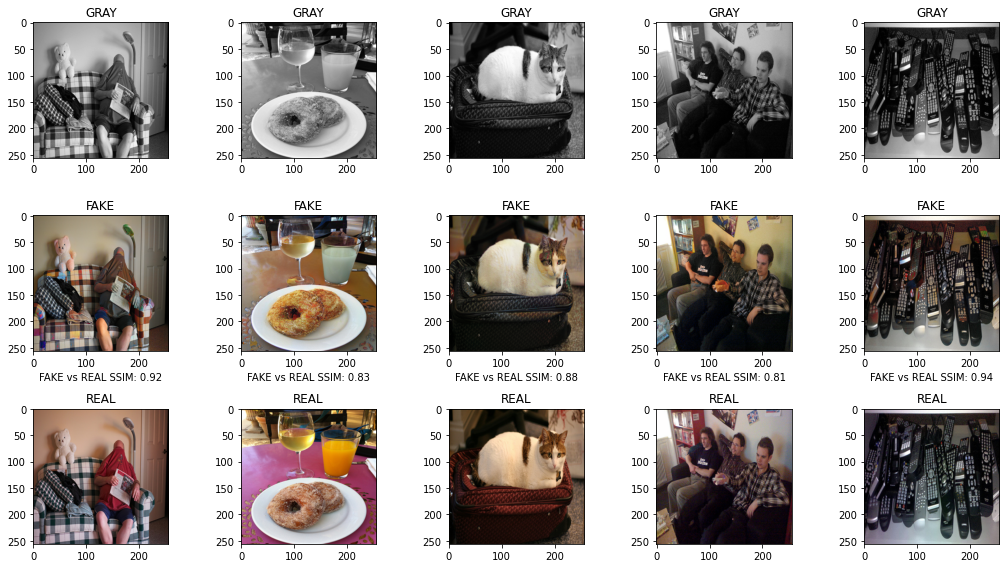

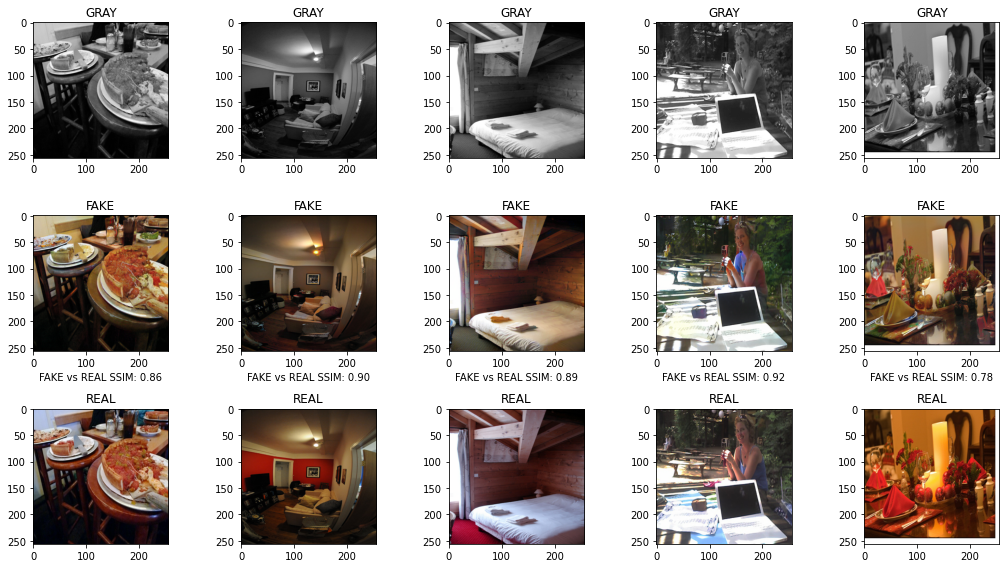

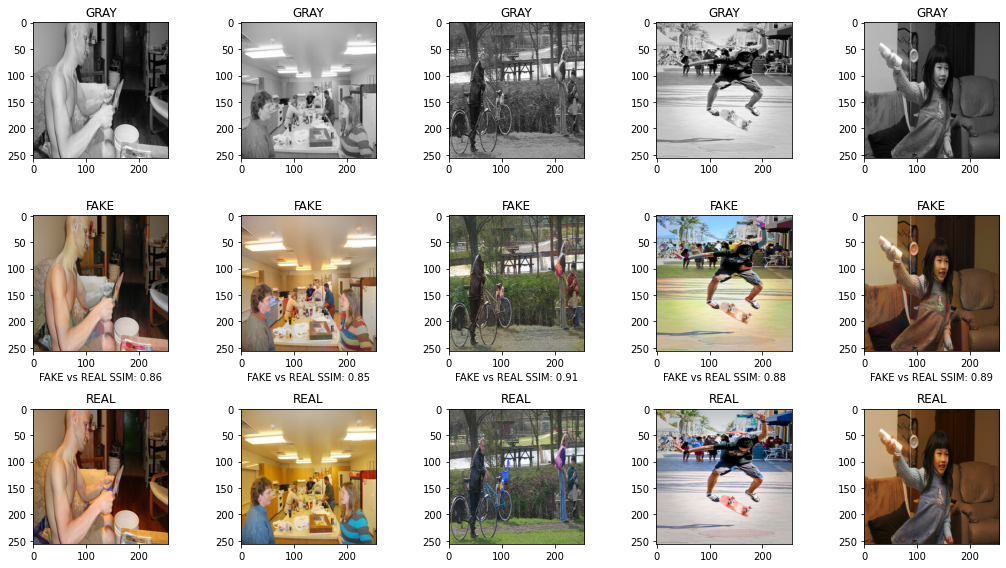

In [167]:
for idx, batch in enumerate(validation_dataloader):
    visualize(model, batch, save=False)
    if idx > 1:
        break
    